In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

In [4]:
api = wandb.Api()

entity = "justin_yang-university-of-california-berkeley"
project = "cs182-project-GPT-opt"
sweep_id = "5pllqyjx" # phase1-safetyfactor

sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: Currently logged in as: bvanlien026 (justin_yang-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [228]:
for run in sweep.runs:
    print(f"Run ID: {run.id}")
    # print("---------- CONFIG ----------")
    # print("Safety Factor:", run.config["optimizer_params"]["args"]["polar_safety"])
    # for key in run.config.keys():
    #     print(key + ":", run.config[key])
    # print(run.summary["svd/update_layer0_v/condition_number"])
    # print("---------- SUMMARY ----------")
    # for key in run.summary.keys():
    #     print(key + ":", run.summary[key])
    # print("---------- HISTORY ----------")
    # for step in run.scan_history():
    #     # print(step["svd/update_layer0_stacked/condition_number"])
    #     for key in step.keys():
    #         print(key)
    #     break
    # break

Run ID: ud9tmam7
Run ID: pgavu9tw
Run ID: oso9lime
Run ID: ly4ms4uh
Run ID: zh36wbcn
Run ID: exhbqbum


In [5]:
def get_data(sweep_id, optimizer_param_name, optimizer_param_vals, update, layer, matrix, metric):

    if update:
        update = "update_"
    else:
        update = ""

    entity = "justin_yang-university-of-california-berkeley"
    project = "cs182-project-GPT-opt"

    api = wandb.Api()
    sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

    data = {val: [] for val in optimizer_param_vals}

    for run in sweep.runs:
        run_id = run.id
        run_param = run.config["optimizer_params"]["args"][optimizer_param_name]

        data[run_param].append(np.array([step[f"svd/{update}layer{layer}_{matrix}/{metric}"] for step in run.scan_history()]))

    return data

In [30]:
def plot_data(sweep_id, param_name, param_id, param_vals, \
              update, layer, matrix, metric, start, end, \
              use_ci=False, log_scale=False, plot_med=True, save_plot=False):

    print("Getting Data...")
    data = get_data(sweep_id, param_id, param_vals, update, layer, matrix, metric)

    if update:
        update = "update_"
    else:
        update = ""

    df = {}
    for val in [1, 1.01]:
    
        arrays = data[val]
        valid_mask = arrays[0] != None
        steps = np.where(valid_mask)[0]
        valid_arrays = [x[valid_mask] for x in arrays]
        valid_arrays = np.asarray(valid_arrays, dtype=float)

        if use_ci:
            med_vec = np.mean(np.stack(valid_arrays), axis=0)
            std_vec = np.std(np.stack(valid_arrays), axis=0)
            N = np.stack(valid_arrays).shape[0]
            sem_vec = std_vec / np.sqrt(N)
            min_vec = med_vec - 1.96 * sem_vec
            max_vec = med_vec + 1.96 * sem_vec
        else:
            med_vec = np.median(np.stack(valid_arrays), axis=0)
            min_vec = np.min(np.stack(valid_arrays), axis=0)
            max_vec = np.max(np.stack(valid_arrays), axis=0)
    
        med_vec = np.asarray(med_vec, dtype=float)
        min_vec = np.asarray(min_vec, dtype=float)
        max_vec = np.asarray(max_vec, dtype=float)
    
        df[f"med_vec_{val}"] = med_vec
        df[f"min_vec_{val}"] = min_vec
        df[f"max_vec_{val}"] = max_vec

        if log_scale:
            df[f"med_vec_{val}"] = np.log(med_vec)
            df[f"min_vec_{val}"] = np.log(min_vec)
            df[f"max_vec_{val}"] = np.log(max_vec)
    
    df["Step"] = steps
    df = pd.DataFrame(df)
    df_iloc = df.iloc[start:end+1]

    print("Plotting Data...")
    sns.set_style("whitegrid")
    for val in [1, 1.01]:
        if plot_med:
            sns.lineplot(data=df_iloc, x="Step", y=f"med_vec_{val}")
        steps = df_iloc["Step"]
        min_vec = df_iloc[f"min_vec_{val}"]
        max_vec = df_iloc[f"max_vec_{val}"]
        plt.fill_between(steps, min_vec, max_vec, alpha=0.3, label=f"{val}");

    plt.title(f"{update.replace("_", "").title()} Layer {layer} {matrix.title()} - {metric.replace("_", " ").title()}")
    plt.xlabel("Step")
    if log_scale:
        plt.ylabel(f"{metric.replace("_", " ").title()} (Log Scale)")
    else:
        plt.ylabel(f"{metric.replace("_", " ").title()}")
    plt.legend(title = param_name)
    
    if save_plot:
        print("Plot Saved.")
        plt.savefig(f"./plots/{param_id}/{metric}/{update}layer{layer}_{matrix}_{metric}_{param_id}.jpg")
    
    plt.show();

Getting Data...
Plotting Data...
Plot Saved.


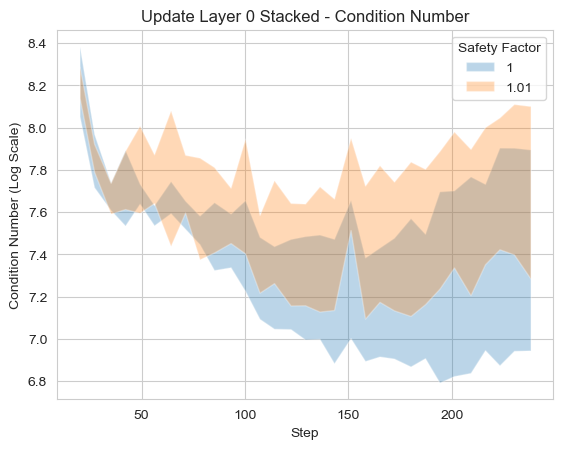

In [40]:
sweep_id = "5pllqyjx"
param_name = "Safety Factor"
param_id = "polar_safety"
param_vals = [1, 1.01]
update = True
layer = 0
matrix = "stacked"
metric = "condition_number"
start = 2
end = 32
use_ci = True
log_scale = True
plot_med = False
save_plot = True

plot_data(sweep_id, param_name, param_id, param_vals, update, layer, matrix, metric, start, end, use_ci, log_scale, plot_med, save_plot)

Getting Data...
Plotting Data...
Plot Saved.


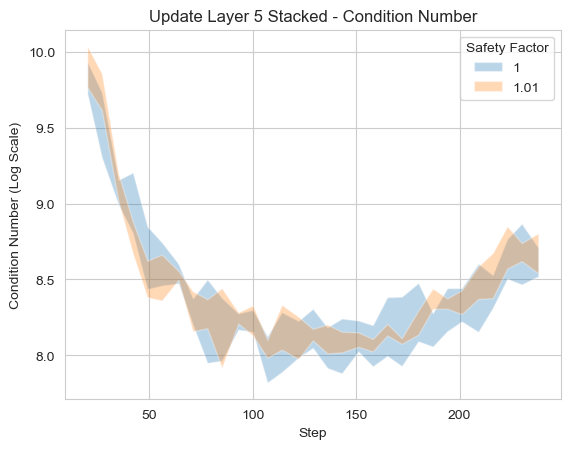

In [41]:
sweep_id = "5pllqyjx"
param_name = "Safety Factor"
param_id = "polar_safety"
param_vals = [1, 1.01]
update = True
layer = 5
matrix = "stacked"
metric = "condition_number"
start = 2
end = 32
use_ci = True
log_scale = True
plot_med = False
save_plot = True

plot_data(sweep_id, param_name, param_id, param_vals, update, layer, matrix, metric, start, end, use_ci, log_scale, plot_med, save_plot)

Getting Data...
Plotting Data...
Plot Saved.


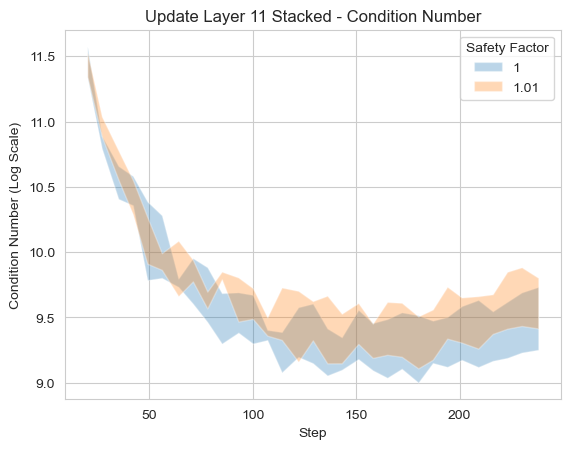

In [42]:
sweep_id = "5pllqyjx"
param_name = "Safety Factor"
param_id = "polar_safety"
param_vals = [1, 1.01]
update = True
layer = 11
matrix = "stacked"
metric = "condition_number"
start = 2
end = 32
use_ci = True
log_scale = True
plot_med = False
save_plot = True

plot_data(sweep_id, param_name, param_id, param_vals, update, layer, matrix, metric, start, end, use_ci, log_scale, plot_med, save_plot)

Getting Data...
Plotting Data...


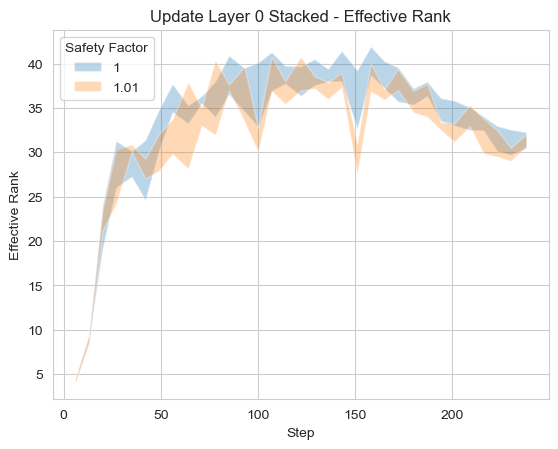

In [39]:
sweep_id = "5pllqyjx"
param_name = "Safety Factor"
param_id = "polar_safety"
param_vals = [1, 1.01]
update = True
layer = 0
matrix = "stacked"
metric = "effective_rank"
start = 0
end = 32
use_ci = True
log_scale = False
plot_med = False
save_plot = False

plot_data(sweep_id, param_name, param_id, param_vals, update, layer, matrix, metric, start, end, use_ci, log_scale, plot_med, save_plot)

Getting Data...
Plotting Data...
Plot Saved.


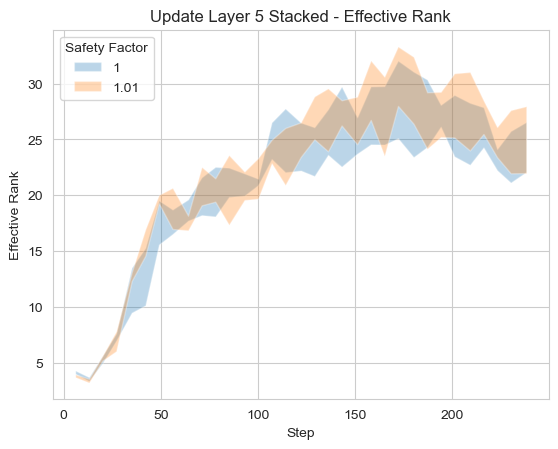

In [234]:
sweep_id = "5pllqyjx"
param_name = "Safety Factor"
param_id = "polar_safety"
param_vals = [1, 1.01]
update = True
layer = 5
matrix = "stacked"
metric = "effective_rank"
start = 0
end = 32
plot_median = False
save_plot = True

plot_data(sweep_id, param_name, param_id, param_vals, update, layer, matrix, metric, start, end, plot_median, save_plot)

Getting Data...
Plotting Data...
Plot Saved.


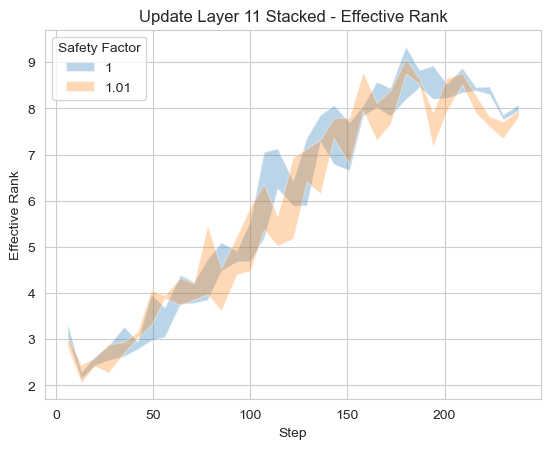

In [235]:
sweep_id = "5pllqyjx"
param_name = "Safety Factor"
param_id = "polar_safety"
param_vals = [1, 1.01]
update = True
layer = 11
matrix = "stacked"
metric = "effective_rank"
start = 0
end = 32
plot_median = False
save_plot = True

plot_data(sweep_id, param_name, param_id, param_vals, update, layer, matrix, metric, start, end, plot_median, save_plot)

Getting Data...
Plotting Data...
Plot Saved.


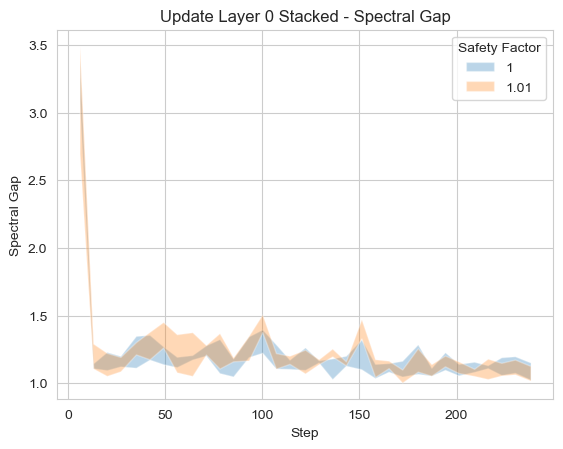

In [236]:
sweep_id = "5pllqyjx"
param_name = "Safety Factor"
param_id = "polar_safety"
param_vals = [1, 1.01]
update = True
layer = 0
matrix = "stacked"
metric = "spectral_gap"
start = 0
end = 32
plot_median = False
save_plot = True

plot_data(sweep_id, param_name, param_id, param_vals, update, layer, matrix, metric, start, end, plot_median, save_plot)

Getting Data...
Plotting Data...
Plot Saved.


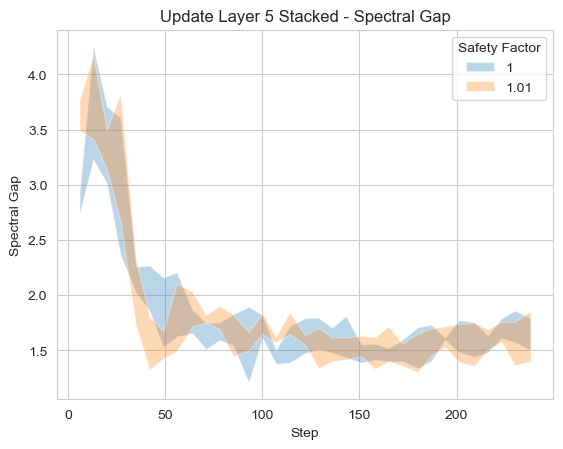

In [237]:
sweep_id = "5pllqyjx"
param_name = "Safety Factor"
param_id = "polar_safety"
param_vals = [1, 1.01]
update = True
layer = 5
matrix = "stacked"
metric = "spectral_gap"
start = 0
end = 32
plot_median = False
save_plot = True

plot_data(sweep_id, param_name, param_id, param_vals, update, layer, matrix, metric, start, end, plot_median, save_plot)

Getting Data...
Plotting Data...
Plot Saved.


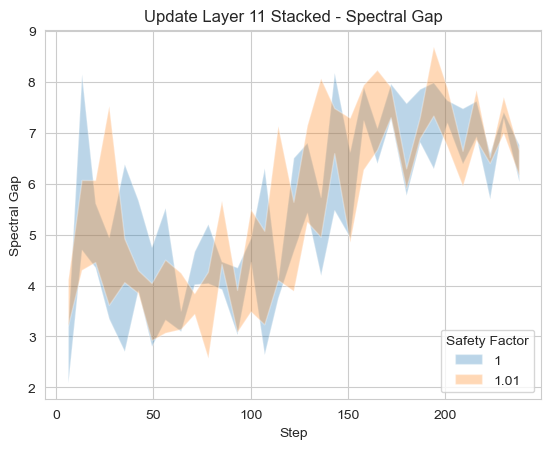

In [238]:
sweep_id = "5pllqyjx"
param_name = "Safety Factor"
param_id = "polar_safety"
param_vals = [1, 1.01]
update = True
layer = 11
matrix = "stacked"
metric = "spectral_gap"
start = 0
end = 32
plot_median = False
save_plot = True

plot_data(sweep_id, param_name, param_id, param_vals, update, layer, matrix, metric, start, end, plot_median, save_plot)